In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt


The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [2]:
download_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/'
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')


## Original PREPROCESSING

Look at keys and attributes of files in training data/ validation data / test data

(only test data that is not fully sampled has "acceleration" as attrs and a "mask" in keys)

In [3]:
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name), 'r')


In [5]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['cs_data', 'grappa_data', 'ismrmrd_header', 'kspace', 'reconstruction_rss', 'sense_data']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0004274357358916608, 'norm': 0.09131797120370877, 'patient_id': 'dcfc3e70496246a709dab23831262b60589f4383d6e05bf5559731ea8d80bb1f'}


In [45]:
file_name = 'file_brain_AXFLAIR_200_6002447.h5'
hf = h5py.File(os.path.join(validation_path, file_name), 'r')


In [6]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['cs_data', 'grappa_data', 'ismrmrd_header', 'kspace', 'reconstruction_rss', 'sense_data']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.00041413615952341293, 'norm': 0.08723472457184536, 'patient_id': '30c14259008242f60e5214a793bad574fbf48a7140f76ec3152eef31e090486d'}


In [7]:
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
hf = h5py.File(os.path.join(test_path, file_name), 'r')


In [8]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['cs_data', 'grappa_data', 'ismrmrd_header', 'kspace', 'mask', 'sense_data']
Attrs: {'acceleration': 8, 'acquisition': 'AXFLAIR', 'num_low_frequency': 13, 'patient_id': 'ca18fce12f2549e69a2db3c660a4d27b116cd79c6ee2437a15db40db7379c723'}


In [5]:
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
hf = h5py.File(os.path.join(fully_sampled_test_path, file_name), 'r')


In [10]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0003919748921278401, 'norm': 0.08606309877132198, 'patient_id': '6002441'}


Get CS mask data

In [7]:
# Real-life CS mask data
import scipy.io as sio
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')
mat_file.keys()


dict_keys(['__header__', '__version__', '__globals__', 'm256_CS1_mask', 'm256_CS2_mask', 'm256_CS4_mask', 'm256_CS6_mask', 'm256_CS8_mask', 'm256_full_mask', 'm320_CS1_mask', 'm320_CS2_mask', 'm320_CS4_mask', 'm320_CS6_mask', 'm320_CS8_mask', 'm320_full_mask'])

Here, we can test our preprocessing approach for training and validation data

In [ ]:
#file_name = 'file_brain_AXFLAIR_200_6002425.h5'
preprocessed_train_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train'
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'r') # Opens in append mode! 'a' instead of 'r'
# CANT WRITE TO FILES OF NYU DATASET, HAVE TO STORE RESULTS YOURSELF


OSError: Unable to create file (unable to open file: name = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_200_6002447.h5', errno = 13, error message = 'Permission denied', flags = 15, o_flags = c2)

In [11]:
from fastmri.data import transforms as T

kspace = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(kspace)))
print("Datatype of the raw kspace: ", str(type(kspace)))


Shape of the raw kspace:  (16, 16, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


In [12]:
# First, we need to create 2 masked versions of k-space:
#   - We need to estimate our sensitivity maps as if we have undersampled data with an ACS region (using ESPIRiT)
#   - We need an actual CS undersampling pattern for the actual reconstruction pipeline itself

## Create ACS masked space for S_i
from fastmri.data.subsample import EquispacedMaskFunc

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_kspace_ACS, mask_ACS = apply_mask(kspace, mask_func) # For validation data we should pass a seed though!


In [13]:
print("Shape of the generated mask: ", str(mask_ACS.shape))
print("Datatype of the generated mask: ", str(type(mask_ACS)))


Shape of the generated mask:  torch.Size([1, 1, 1, 320, 1])
Datatype of the generated mask:  <class 'torch.Tensor'>


In [14]:
## create real world CS undersampling 

def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

def generate_array(shape, R, mat_file, tensor_out):
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]
    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array

mask = generate_array(kspace.shape, 4, mat_file, tensor_out=False)
masked_kspace = kspace * mask + 0.0


In [15]:
print("Shape of the generated mask: ", str(mask.shape))
print("Datatype of the generated mask: ", str(type(mask)))


Shape of the generated mask:  (1, 1, 1, 320)
Datatype of the generated mask:  <class 'numpy.ndarray'>


In [16]:
# Now, let's preform a slice-wise ESPIRiT and CS estimation (TAKES LONG CAUSE IS FOR ALL SLICES!!)

import bart

def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {}'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction

cs_data = np.zeros((kspace.shape[0], kspace.shape[2], kspace.shape[3]), dtype=np.complex64)

for slice in range(kspace.shape[0]):
    S = estimate_sensitivity_maps(masked_kspace_ACS[slice,:,:,:])   # with ACS region!
    cs_data[slice,:,:] = CS(masked_kspace[slice,:,:,:], S)          # with real life CS_kspace

print("Shape of the numpy-converted CS data: ", str(cs_data.shape))
print("Type of the numpy-converted CS data: ", str(type(cs_data)))


Shape of the numpy-converted CS data:  (16, 640, 320)
Type of the numpy-converted CS data:  <class 'numpy.ndarray'>


In [ ]:
plt.imshow(np.abs(cs_data[10,:,:]), cmap='gray')

## TEST ZERO-PADDING before/after BART:

Select a file

In [3]:
# Select a file and save in hf
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name), 'r')

How does it work for files of size (768, 396), where we cut the FE direction to 640??

file names to test:
file_brain_AXT2_209_2090111.h5

file_brain_AXT2_200_2000507.h5

file_brain_AXT2_200_6002445.h5

file_brain_AXT2_200_2000469.h5

file_brain_AXT2_201_2010349.h5

file_brain_AXT2_201_2010029.h5

file_brain_AXT2_210_2100332.h5

file_brain_AXT2_200_6002214.h5

file_brain_AXT2_210_6001756.h5


In [43]:
file_name = "file_brain_AXT2_200_6002214.h5"
hf = h5py.File(os.path.join(train_path, file_name), 'r')



Get k-space + create masked_versions of k-space

In [44]:
# Get k-space
from fastmri.data import transforms as T

kspace = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(kspace)))
print("Datatype of the raw kspace: ", str(type(kspace)))

Shape of the raw kspace:  (16, 16, 768, 396)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


Shape kspace = (number of slices, number of coils, height, width)

In [45]:
# First, we need to create 2 masked versions of k-space:
#   - We need to estimate our sensitivity maps as if we have undersampled data with an ACS region (using ESPIRiT)
#   - We need an actual CS undersampling pattern for the actual reconstruction pipeline itself

## Create ACS masked space for S_i
from fastmri.data.subsample import EquispacedMaskFunc

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_kspace_ACS, mask_ACS = apply_mask(kspace, mask_func) # For validation data we should pass a seed though!

print("Shape of the generated mask: ", str(mask_ACS.shape))
print("Datatype of the generated mask: ", str(type(mask_ACS)))

Shape of the generated mask:  torch.Size([1, 1, 1, 396, 1])
Datatype of the generated mask:  <class 'torch.Tensor'>


In [46]:
## create real world CS undersampling 
# SELECT ACCELERATION FACTOR
R = 4

# get Real-life CS mask data
import scipy.io as sio
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')
mat_file.keys()

def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

def generate_array(shape, R, mat_file, tensor_out):
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]
    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array

mask = generate_array(kspace.shape, R, mat_file, tensor_out=False)
masked_kspace = kspace * mask + 0.0

PERFORM BART reconstructions with zero-padded k-space (before and after )

Processing middle slice: 8
Method 1: Zero-padding k-space before BART
(16, 640, 640)
(16, 640, 640)
Method 1 execution time: 30.9188 seconds
Method 1 output shape: (640, 640)
Method 2: BART reconstruction first, then sinc interpolation
(1, 640, 640)
Method 2 execution time: 25.2013 seconds
Method 2 output shape: (640, 640)

Time comparison:
Method 1 (k-space zero-padding before BART): 30.9188 seconds
Method 2 (BART then sinc interpolation): 25.2013 seconds
Difference: 5.7175 seconds
Method 2 is faster
Mean absolute difference between methods: 2.780918475764338e-05
Max absolute difference between methods: 0.0006052551907487214


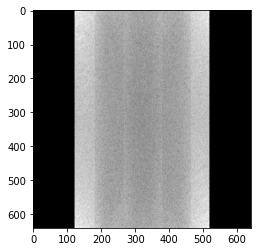

In [47]:
import bart
import numpy as np
import time
import torch
from scipy.fft import ifft2, fft2

def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {}'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction

def zero_pad_kspace(kspace, target_size):
    """
    Zero-pad k-space to achieve sinc interpolation in image domain
    
    Args:
        kspace (numpy.array): K-space data (can be 2D or 3D with num_coils)
        target_size (tuple): Target size (rows, cols)
    
    Returns:
        kspace_padded (numpy.array): Zero-padded k-space
    """
    is_3d = len(kspace.shape) == 3  # Check if num_coils dimension exists
    if not is_3d:
        kspace = kspace[np.newaxis, ...]  # Add dummy coil dimension

    rows, cols = kspace.shape[-2], kspace.shape[-1]
    target_rows, target_cols = target_size

    # Convert k-space to fastMRI expected format (real, imag) -> shape (num_coils, rows, cols, 2)
    kspace_tensor = T.to_tensor(kspace)

     # Handle cropping if the size is too large
    if rows > target_rows and cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, target_size)
        rows = target_rows
        cols = target_cols

     # if only 1 dimension is too large, crop that dimension   
    if rows > target_rows:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (target_rows, cols))
        rows = target_rows
    
    if cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (rows, target_cols))
        cols = target_cols

    # Handle zero-padding if the size is too small
    if rows < target_rows or cols < target_cols:
        pad_rows = target_rows - rows
        pad_cols = target_cols - cols
        
        pad_top = pad_rows // 2
        pad_bottom = pad_rows - pad_top
        pad_left = pad_cols // 2
        pad_right = pad_cols - pad_left
        
        # Apply zero padding to 3D array
        kspace_tensor = torch.nn.functional.pad(
            kspace_tensor, (0, 0, pad_left, pad_right, pad_top, pad_bottom)
        )

    kspace_padded = T.tensor_to_complex_np(kspace_tensor)
    print(kspace_padded.shape)
    return kspace_padded if is_3d else kspace_padded[0]  # Remove dummy coil dimension if needed

def image_domain_zero_pad(image, target_size):
    """
    Perform sinc interpolation by IFT, zero-padding, FT
    
    Args:
        image (numpy.array): Image domain data (rows, cols)
        target_size (tuple): Target size (rows, cols)
    
    Returns:
        interpolated_image (numpy.array): Sinc interpolated image
    """
    # Convert to k-space
    kspace = fft2(image)
    
    # Zero-pad or crop k-space
    adjusted_kspace = zero_pad_kspace(kspace, target_size)

    #plt.imshow(padded_kspace, cmap='gray')
    plt.imshow(np.log(1e-7 + np.abs(adjusted_kspace)), cmap='gray')
    
    # Convert back to image domain
    interpolated_image = ifft2(adjusted_kspace)
    
    return interpolated_image

# Select the middle slice
middle_slice_idx = kspace.shape[0] // 2
print(f"Processing middle slice: {middle_slice_idx}")

# Target size for Unet compatibility (make sure it's divisible by 2^N where N is the depth of Unet)
target_size = (640, 640)  # Adjust as needed for your Unet architecture

# Method 1: Zero-padding k-space before BART
print("Method 1: Zero-padding k-space before BART")
start_time = time.time()

# Get the middle slice
middle_slice_kspace = masked_kspace[middle_slice_idx, :, :, :]
middle_slice_kspace_ACS = masked_kspace_ACS[middle_slice_idx, :, :, :]

# Zero-pad k-space
padded_kspace = zero_pad_kspace(middle_slice_kspace, target_size)
padded_kspace_ACS = zero_pad_kspace(middle_slice_kspace_ACS, target_size)

# Estimate sensitivity maps and perform CS
S_padded = estimate_sensitivity_maps(padded_kspace_ACS)
cs_result_method1 = CS(padded_kspace, S_padded)

method1_time = time.time() - start_time
print(f"Method 1 execution time: {method1_time:.4f} seconds")
print(f"Method 1 output shape: {cs_result_method1.shape}")

# Method 2: Perform BART reconstruction first, then do sinc interpolation in image domain
print("Method 2: BART reconstruction first, then sinc interpolation")
start_time = time.time()

# Estimate sensitivity maps and perform CS on original data
S_original = estimate_sensitivity_maps(middle_slice_kspace_ACS)
cs_result_original = CS(middle_slice_kspace, S_original)

# Perform sinc interpolation in image domain
cs_result_method2 = image_domain_zero_pad(cs_result_original, target_size)

method2_time = time.time() - start_time
print(f"Method 2 execution time: {method2_time:.4f} seconds")
print(f"Method 2 output shape: {cs_result_method2.shape}")

# Compare execution times
print("\nTime comparison:")
print(f"Method 1 (k-space zero-padding before BART): {method1_time:.4f} seconds")
print(f"Method 2 (BART then sinc interpolation): {method2_time:.4f} seconds")
print(f"Difference: {abs(method1_time - method2_time):.4f} seconds")
print(f"Method {'1' if method1_time < method2_time else '2'} is faster")

# Optionally, compute difference between the results to check if they're equivalent
diff = np.abs(cs_result_method1 - cs_result_method2)
print(f"Mean absolute difference between methods: {np.mean(diff)}")
print(f"Max absolute difference between methods: {np.max(diff)}")

In [48]:
# Method 3: Original reconstruction (no zero padding)
print("\nMethod 3: Original reconstruction (no zero padding)")
start_time = time.time()

# Get the middle slice (same as before)
middle_slice_kspace = masked_kspace[middle_slice_idx, :, :, :]
middle_slice_kspace_ACS = masked_kspace_ACS[middle_slice_idx, :, :, :]

# Estimate sensitivity maps and perform CS directly on original data
S_original = estimate_sensitivity_maps(middle_slice_kspace_ACS)
cs_result_method3 = CS(middle_slice_kspace, S_original)

method3_time = time.time() - start_time
print(f"Method 3 execution time: {method3_time:.4f} seconds")
print(f"Method 3 output shape: {cs_result_method3.shape}")


Method 3: Original reconstruction (no zero padding)


Method 3 execution time: 24.1427 seconds
Method 3 output shape: (768, 396)


In [49]:
# Compare execution times
print("\nTime comparison:")
print(f"Method 1 (k-space zero-padding before BART): {method1_time:.4f} seconds")
print(f"Method 2 (BART then sinc interpolation): {method2_time:.4f} seconds")
print(f"Method 3 (Original with no padding): {method3_time:.4f} seconds")

print(f"Method {'1' if method1_time < min(method2_time, method3_time) else ('2' if method2_time < method3_time else '3')} is fastest")


Time comparison:
Method 1 (k-space zero-padding before BART): 30.9188 seconds
Method 2 (BART then sinc interpolation): 25.2013 seconds
Method 3 (Original with no padding): 24.1427 seconds
Method 3 is fastest


FORGOT: still need to take AV + normalize before comparing (just like Mathijs did after cropping/zerofilling)

In [50]:
import torch
import fastmri
from fastmri.data import transforms as T


def preprocess_mri(image, clamp_range=(-6, 6), eps=1e-11):
    """
    Applies AV (absolute value for complex images) and normalizes an MRI image.
    
    Args:
        image (numpy.ndarray or tensor): Input image, possibly complex.
        clamp_range (tuple): Range for clamping values after normalization.
        eps (float): Small epsilon to prevent division by zero in normalization.
    
    Returns:
        (torch.Tensor: Processed image.)
        numpy.ndarray: processed image
    """
    # Convert to tensor if it's a numpy array
    if isinstance(image, np.ndarray):
        image = T.to_tensor(image)
    
    # Take absolute value (AV)
    image = fastmri.complex_abs(image)
    
    # Normalize
    image, _, _ = T.normalize_instance(image, eps=eps)
    image = image.clamp(*clamp_range)
    image = image.numpy() #return numpy array instead of tensor
    return image

cs_result_method1 = preprocess_mri(cs_result_method1)
cs_result_method2 = preprocess_mri(cs_result_method2)
cs_result_method3 = preprocess_mri(cs_result_method3)


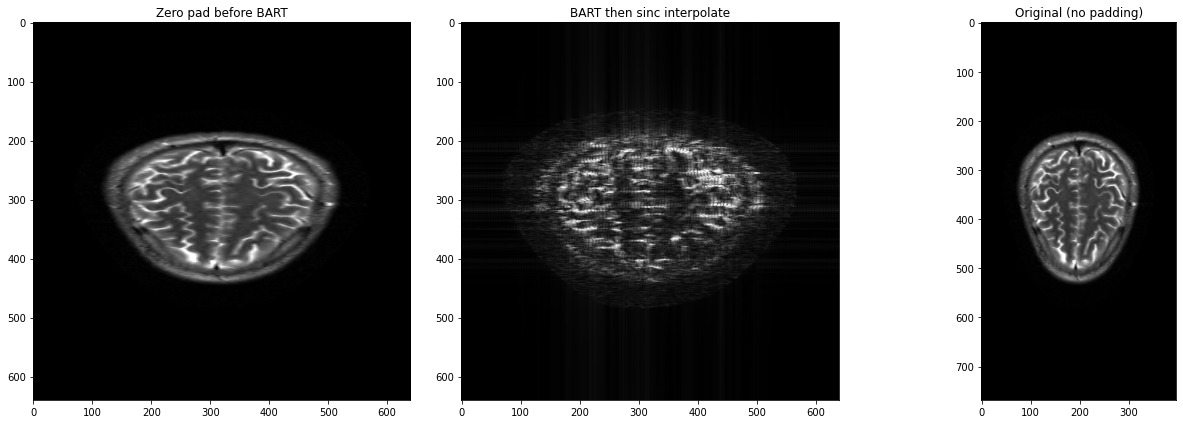

In [51]:
# Plot all three methods for comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Zero pad before BART", "BART then sinc interpolate", "Original (no padding)"]

axs[0].imshow(cs_result_method1, cmap='gray')
axs[0].set_title(titles[0])

axs[1].imshow(cs_result_method2, cmap='gray')
axs[1].set_title(titles[1])

axs[2].imshow(cs_result_method3, cmap='gray')
axs[2].set_title(titles[2])

plt.tight_layout()
plt.show()

# !!plots are wrong, need to account for real matrices before zero-padding to not get a stretched image!

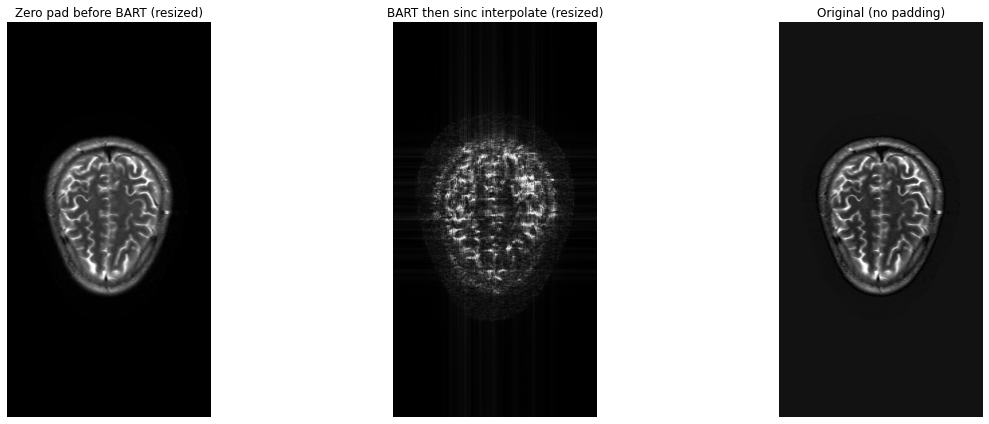

Mean absolute difference between method1 and original: 0.01818970963358879
Max absolute difference between method1 and original: 1.1057727336883545
Mean absolute difference between method2 and original: 0.29889124631881714
Max absolute difference between method2 and original: 6.065159797668457


In [52]:
# Alternative approach: Resize high-res images to match original dimensions
from skimage.transform import resize

# Plot all three methods for comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Zero pad before BART", "BART then sinc interpolate", "Original (no padding)"]

# Resize high-res images to match original dimensions
cs_result_method1_resized = resize(cs_result_method1, cs_result_method3.shape, 
                                  anti_aliasing=True, preserve_range=True)
cs_result_method2_resized = resize(cs_result_method2, cs_result_method3.shape, 
                                  anti_aliasing=True, preserve_range=True)

axs[0].imshow(cs_result_method1_resized, cmap='gray')
axs[0].set_title(titles[0] + " (resized)")

axs[1].imshow(cs_result_method2_resized, cmap='gray')
axs[1].set_title(titles[1] + " (resized)")

axs[2].imshow(np.abs(cs_result_method3), cmap='gray')
axs[2].set_title(titles[2])

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# compute difference between the results to check if they're equivalent
diff1 = np.abs(cs_result_method1_resized - cs_result_method3)
diff2 = np.abs(cs_result_method2_resized - cs_result_method3)
print(f"Mean absolute difference between method1 and original: {np.mean(diff1)}") 
print(f"Max absolute difference between method1 and original: {np.max(diff1)}")
print(f"Mean absolute difference between method2 and original: {np.mean(diff2)}")
print(f"Max absolute difference between method2 and original: {np.max(diff2)}")

Use Structural Similarity Index (SSIM)

In [53]:
### copied code from evaluate.py (has function for ssim)
from skimage.metrics import structural_similarity
from typing import Optional

def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]

# Ensure the results are 3D by adding a dummy dimension
img1 = cs_result_method1_resized[np.newaxis, ...]  # Shape (1, H, W)
img2 = cs_result_method2_resized[np.newaxis, ...]  # Shape (1, H, W)
img_ref = cs_result_method3[np.newaxis, ...]  # Shape (1, H, W)

# Compute SSIM using your function
ssim1 = ssim(img_ref, img1)
ssim2 = ssim(img_ref, img2)

print(f"SSIM between Method 1 and Original: {ssim1[0]:.4f}")
print(f"SSIM between Method 2 and Original: {ssim2[0]:.4f}")


SSIM between Method 1 and Original: 0.9920
SSIM between Method 2 and Original: 0.6643


In [54]:
from skimage.metrics import structural_similarity as ssim

ssim1 = ssim((cs_result_method1_resized), (cs_result_method3), 
             data_range=(cs_result_method3).max())

ssim2 = ssim((cs_result_method2_resized), (cs_result_method3), 
             data_range=(cs_result_method3).max())

print(f"SSIM between Method 1 and Original: {ssim1:.4f}")
print(f"SSIM between Method 2 and Original: {ssim2:.4f}")


SSIM between Method 1 and Original: 0.9920
SSIM between Method 2 and Original: 0.6643


### Improved Ways to visually Compare the Methods

#### Visualizing Absolute Difference Maps (Best for Identifying Artifacts)

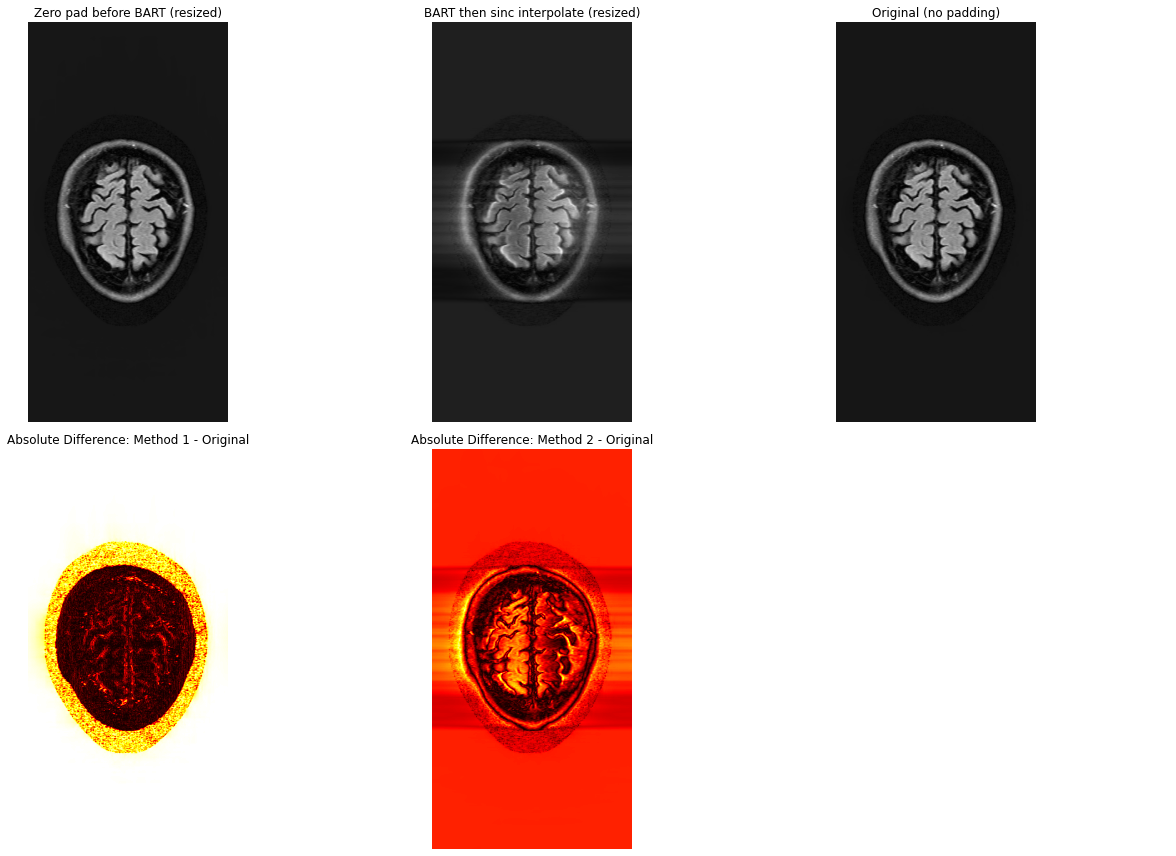

In [102]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

titles = [
    "Zero pad before BART (resized)", 
    "BART then sinc interpolate (resized)", 
    "Original (no padding)",
    "Absolute Difference: Method 1 - Original",
    "Absolute Difference: Method 2 - Original"
]

# First row: reconstructed images
axs[0, 0].imshow(cs_result_method1_resized, cmap='gray')
axs[0, 0].set_title(titles[0])

axs[0, 1].imshow(cs_result_method2_resized, cmap='gray')
axs[0, 1].set_title(titles[1])

axs[0, 2].imshow(np.abs(cs_result_method3), cmap='gray')
axs[0, 2].set_title(titles[2])

# Compute absolute difference
diff1 = np.abs(cs_result_method1_resized - cs_result_method3)
diff2 = np.abs(cs_result_method2_resized - cs_result_method3)

# Second row: absolute difference maps
axs[1, 0].imshow(diff1, cmap='hot')
axs[1, 0].set_title(titles[3])

axs[1, 1].imshow(diff2, cmap='hot')
axs[1, 1].set_title(titles[4])

axs[1, 2].axis("off")  # Leave one plot blank

# Hide axes
for ax in axs.flatten():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

#### Are the differences intensity related? => need normalization or histogram matching to make the intensity distributions comparable

##### Histogram matching

Method 1 - Min: 0.001513, Max: 5.199852
Method 2 - Min: 0.011390, Max: 4.466312
Original - Min: 0.000008, Max: 5.354820


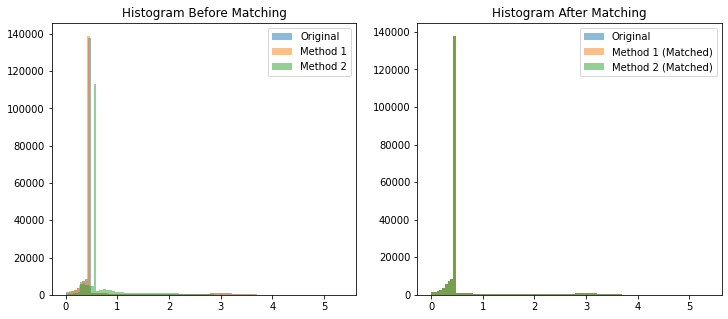

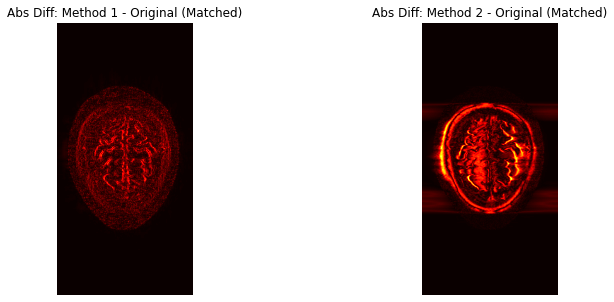

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms

# Ensure images are non-zero
method1_real = np.abs(cs_result_method1_resized)
method2_real = np.abs(cs_result_method2_resized)
original_real = np.abs(cs_result_method3)

# Check for minimum and maximum values
print(f"Method 1 - Min: {method1_real.min():.6f}, Max: {method1_real.max():.6f}")
print(f"Method 2 - Min: {method2_real.min():.6f}, Max: {method2_real.max():.6f}")
print(f"Original - Min: {original_real.min():.6f}, Max: {original_real.max():.6f}")

# Apply histogram matching
method1_matched = match_histograms(method1_real, original_real)
method2_matched = match_histograms(method2_real, original_real)

# Compute absolute difference after histogram matching
abs_diff1 = np.abs(method1_matched - original_real)
abs_diff2 = np.abs(method2_matched - original_real)

# Plot histograms before and after matching
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(original_real.ravel(), bins=100, alpha=0.5, label="Original")
plt.hist(method1_real.ravel(), bins=100, alpha=0.5, label="Method 1")
plt.hist(method2_real.ravel(), bins=100, alpha=0.5, label="Method 2")
plt.legend()
plt.title("Histogram Before Matching")

plt.subplot(1, 2, 2)
plt.hist(original_real.ravel(), bins=100, alpha=0.5, label="Original")
plt.hist(method1_matched.ravel(), bins=100, alpha=0.5, label="Method 1 (Matched)")
plt.hist(method2_matched.ravel(), bins=100, alpha=0.5, label="Method 2 (Matched)")
plt.legend()
plt.title("Histogram After Matching")

plt.show()

# Plot absolute difference images
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(abs_diff1, cmap="hot")
axs[0].set_title("Abs Diff: Method 1 - Original (Matched)")
axs[1].imshow(abs_diff2, cmap="hot")
axs[1].set_title("Abs Diff: Method 2 - Original (Matched)")

for ax in axs:
    ax.set_axis_off()

plt.show()


In [104]:
from skimage.metrics import structural_similarity as ssim

ssim1 = ssim(np.abs(method1_matched), np.abs(cs_result_method3), 
             data_range=np.abs(cs_result_method3).max() - np.abs(cs_result_method3).min())

ssim2 = ssim(np.abs(method2_matched), np.abs(cs_result_method3), 
             data_range=np.abs(cs_result_method3).max() - np.abs(cs_result_method3).min())

print(f"SSIM between Method 1 and Original: {ssim1:.4f}")
print(f"SSIM between Method 2 and Original: {ssim2:.4f}")

SSIM between Method 1 and Original: 0.9864
SSIM between Method 2 and Original: 0.8628


##### Min max normalization

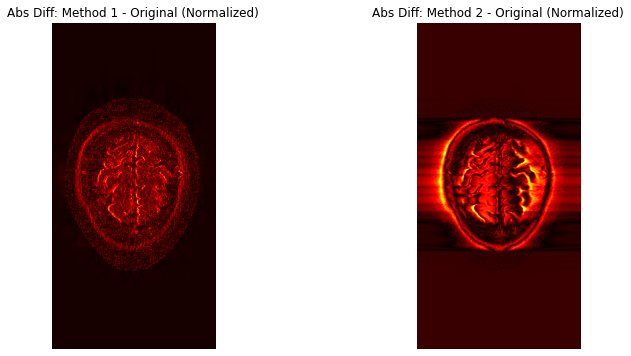

Method 1 - Mean: 0.006072, Std: 0.008737
Method 2 - Mean: 0.057904, Std: 0.056615


In [105]:
def min_max_normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# Apply normalization to all images
original_norm = min_max_normalize(original_real)
method1_norm = min_max_normalize(method1_real)
method2_norm = min_max_normalize(method2_real)

# Compute absolute differences after normalization
diff1_norm = np.abs(method1_norm - original_norm)
diff2_norm = np.abs(method2_norm - original_norm)

# Display normalized absolute difference maps
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(diff1_norm, cmap='hot')
axs[0].set_title("Abs Diff: Method 1 - Original (Normalized)")

axs[1].imshow(diff2_norm, cmap='hot')
axs[1].set_title("Abs Diff: Method 2 - Original (Normalized)")
for ax in axs:
    ax.set_axis_off()

plt.show()

# Compute new statistics
print(f"Method 1 - Mean: {np.mean(diff1_norm):.6f}, Std: {np.std(diff1_norm):.6f}")
print(f"Method 2 - Mean: {np.mean(diff2_norm):.6f}, Std: {np.std(diff2_norm):.6f}")


In [106]:
from skimage.metrics import structural_similarity as ssim

ssim_method1 = ssim(original_norm, method1_norm, data_range=1)
ssim_method2 = ssim(original_norm, method2_norm, data_range=1)

print(f"SSIM Method 1 vs Original: {ssim_method1:.6f}")
print(f"SSIM Method 2 vs Original: {ssim_method2:.6f}")


SSIM Method 1 vs Original: 0.986031
SSIM Method 2 vs Original: 0.824651


## Here, we can test our preprocessing approach for test data

In [33]:
# R = 8
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
preprocessed_train_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test'
preprocessed_train_path_full = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full'


In [34]:
# First, find out what the value of R is
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'r') # Open in read mode!
nPE_mask = hf['mask'][()]
sampled_columns = np.sum(nPE_mask)
R = len(nPE_mask)/sampled_columns
R = float(R)
print(R)


8.0


In [35]:
# Also, use the official test scan ACS region for the sensitivity map estimation
masked_kspace_ACS = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(masked_kspace_ACS)))
print("Datatype of the raw kspace: ", str(type(masked_kspace_ACS)))


Shape of the raw kspace:  (16, 20, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


In [36]:
# Now, knowing R, create a CS kspace version from the scan's multicoil_test_full file
def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

hf = h5py.File(os.path.join(preprocessed_train_path_full, file_name), 'r') # Open in read mode!
kspace = hf['kspace'][()]
mask = generate_array(kspace.shape, closer_to_4_or_8(R), mat_file, tensor_out=False)
masked_kspace = kspace * mask + 0.0


In [ ]:
# Now, let's preform a slice-wise ESPIRiT and CS estimation
cs_data = np.zeros((masked_kspace.shape[0], masked_kspace.shape[2], masked_kspace.shape[3]), dtype=np.complex64)

for slice in range(masked_kspace.shape[0]):
    S = estimate_sensitivity_maps(masked_kspace_ACS[slice,:,:,:])
    cs_data[slice,:,:] = CS(masked_kspace[slice,:,:,:], S)

print("Shape of the numpy-converted CS data: ", str(cs_data.shape))
print("Type of the numpy-converted CS data: ", str(type(cs_data)))


Shape of the numpy-converted CS data:  (16, 640, 320)
Type of the numpy-converted CS data:  <class 'numpy.ndarray'>


: 

: 

: 

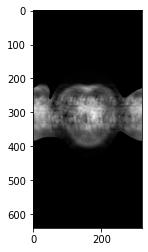

: 

: 

: 

In [ ]:
plt.imshow(np.abs(cs_data[10,:,:]), cmap='gray')


In [ ]:
# Write cs_data away
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'a') # Open in append mode!
# ...


OSError: Unable to create file (unable to open file: name = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_200_6002441.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

: 

: 

: 

In [ ]:
# R = 4
file_name = 'file_brain_AXFLAIR_209_6001340.h5'

: 

: 

: 

In [ ]:
# First, find out what the value of R is
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'r') # Open in read mode!
nPE_mask = hf['mask'][()]
sampled_columns = np.sum(nPE_mask)
R = len(nPE_mask)/sampled_columns
R = float(R)
print(R)


4.0


: 

: 

: 

In [ ]:
# Also, use the official test scan ACS region for the sensitivity map estimation
masked_kspace_ACS = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(masked_kspace_ACS)))
print("Datatype of the raw kspace: ", str(type(masked_kspace_ACS)))


Shape of the raw kspace:  (16, 14, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


: 

: 

: 

In [ ]:
# Now, knowing R, create a CS kspace version from the scan's multicoil_test_full file
def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

hf = h5py.File(os.path.join(preprocessed_train_path_full, file_name), 'r') # Open in read mode!
kspace = hf['kspace'][()]
mask = generate_array(kspace.shape, closer_to_4_or_8(R), mat_file, tensor_out=False)
masked_kspace = kspace * mask + 0.0


: 

: 

: 

In [ ]:
# Now, let's preform a slice-wise ESPIRiT and CS estimation
cs_data = np.zeros((masked_kspace.shape[0], masked_kspace.shape[2], masked_kspace.shape[3]), dtype=np.complex64)

for slice in range(masked_kspace.shape[0]):
    S = estimate_sensitivity_maps(masked_kspace_ACS[slice,:,:,:])
    cs_data[slice,:,:] = CS(masked_kspace[slice,:,:,:], S)

print("Shape of the numpy-converted CS data: ", str(cs_data.shape))
print("Type of the numpy-converted CS data: ", str(type(cs_data)))


Shape of the numpy-converted CS data:  (16, 640, 320)
Type of the numpy-converted CS data:  <class 'numpy.ndarray'>


: 

: 

: 

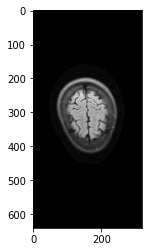

: 

: 

: 

In [ ]:
plt.imshow(np.abs(cs_data[10,:,:]), cmap='gray')


Here, we can test a loop which loops through the files in the folders we specify

In [ ]:
from pathlib import Path

folder_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/'
files = Path(folder_path).glob('**/*')
for file in files:
    print(file)


/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT1POST_203_6000790.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_209_2090032.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_205_6000143.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_202_6000578.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_200_6002431.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_209_2090309.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_209_6001383.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_202_2020417.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_201_6002955.

: 

: 

: 

In [ ]:
from pathlib import Path

folder_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/'
files = Path(folder_path).glob('**/*')
for file in files:
    print(file.name)
    print('/folder/path/'+file.name)


file_brain_AXT1POST_203_6000790.h5
/folder/path/file_brain_AXT1POST_203_6000790.h5
file_brain_AXT2_209_2090032.h5
/folder/path/file_brain_AXT2_209_2090032.h5
file_brain_AXT2_205_6000143.h5
/folder/path/file_brain_AXT2_205_6000143.h5
file_brain_AXFLAIR_202_6000578.h5
/folder/path/file_brain_AXFLAIR_202_6000578.h5
file_brain_AXT2_200_6002431.h5
/folder/path/file_brain_AXT2_200_6002431.h5
file_brain_AXT2_209_2090309.h5
/folder/path/file_brain_AXT2_209_2090309.h5
file_brain_AXFLAIR_209_6001383.h5
/folder/path/file_brain_AXFLAIR_209_6001383.h5
file_brain_AXT2_202_2020417.h5
/folder/path/file_brain_AXT2_202_2020417.h5
file_brain_AXFLAIR_201_6002955.h5
/folder/path/file_brain_AXFLAIR_201_6002955.h5
file_brain_AXT2_208_2080716.h5
/folder/path/file_brain_AXT2_208_2080716.h5
file_brain_AXT2_200_2000498.h5
/folder/path/file_brain_AXT2_200_2000498.h5
file_brain_AXFLAIR_201_6003013.h5
/folder/path/file_brain_AXFLAIR_201_6003013.h5
file_brain_AXT2_203_2030129.h5
/folder/path/file_brain_AXT2_203_2030

: 

: 

: 